In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.patches as patches


In [2]:
df_recuperado = pd.read_csv('../pruebas_perfilometria/perfiles_7.csv')
diccionario_recuperado = {i: group[['X', 'Y']].values for i, group in df_recuperado.groupby('Array_ID')}


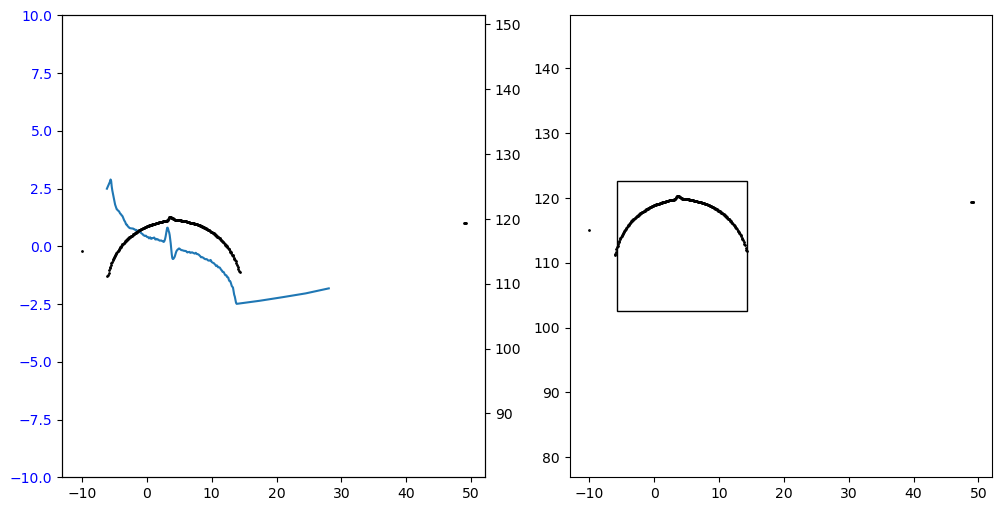

In [62]:
def funcion_para_reconocer_interseccion(xy_data, x_intersec):
    # Ordenar los puntos según el eje x
    xy_data = xy_data[xy_data[:, 0].argsort()]

    # Extraer las columnas x e y
    x_vals = xy_data[:, 0]
    y_vals = xy_data[:, 1]

    # Verificar si x_intersec está exactamente en los datos
    if x_intersec in x_vals:
        return y_vals[np.where(x_vals == x_intersec)][0]

    # Si no está, buscamos los dos puntos más cercanos para interpolar
    idx_below = np.searchsorted(x_vals, x_intersec) - 1
    idx_above = idx_below + 1

    if idx_below < 0 or idx_above >= len(x_vals):
        raise ValueError("El valor de x_intersec está fuera del rango de los datos")

    # Puntos más cercanos
    x_below, y_below = x_vals[idx_below], y_vals[idx_below]
    x_above, y_above = x_vals[idx_above], y_vals[idx_above]

    # Interpolación lineal
    y_intersec = y_below + (y_above - y_below) * (x_intersec - x_below) / (x_above - x_below)
    
    return y_intersec

def moving_average(arr, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(arr, window, mode='valid')

def funcion_principal(xy_data, R = 20, vis_der=False):

    x = xy_data[:, 0]
    y = xy_data[:, 1]

    dy_dx = np.gradient(y, x)
    derivada_xy = np.column_stack((x, dy_dx))
    derivada_xy = derivada_xy[(derivada_xy[:, 1] >= -10) & (derivada_xy[:, 1] <= 10)]
    k = 10
    smoothed_data = np.zeros_like(derivada_xy)
    for i in range(derivada_xy.shape[1]):
        smoothed_data[:, i] = np.concatenate([moving_average(derivada_xy[:, i], k), np.full(k-1, np.nan)])

    x_semicirc_deriv = np.linspace(-R,R,100)
    x_semicirc_deriv = x_semicirc_deriv[1:-1]
    y_semicirc_deriv = -x_semicirc_deriv/np.sqrt(R**2-x_semicirc_deriv**2)

    d_large = smoothed_data
    semicirc_deriv = np.column_stack((x_semicirc_deriv, y_semicirc_deriv))
    discr = 0.01


    xnew_large = np.arange(np.nanmin(smoothed_data[:, 0]), np.nanmax(smoothed_data[:, 0]),discr)
    f_large = interp1d(smoothed_data[:, 0], smoothed_data[:, 1])
    ynew_large = f_large(xnew_large)
    xnew_small = np.arange(np.nanmin(semicirc_deriv[:, 0]), np.nanmax(semicirc_deriv[:, 0]),discr)
    f_small = interp1d(semicirc_deriv[:, 0], semicirc_deriv[:, 1])
    ynew_small = f_small(xnew_small)

    dists = []
    for i in range(len(ynew_large)-len(ynew_small)):
        ynew_large_new = ynew_large[i:len(ynew_small)+i]
        dists.append(sum(abs(ynew_large_new-ynew_small)/len(ynew_large_new)))

    x_intersec = xnew_large[np.argmin(np.array(dists))]
    y_intersec = funcion_para_reconocer_interseccion(points, x_intersec)

    if vis_der:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        ax12 = ax1.twinx()
        ax1.plot(smoothed_data[:, 0], smoothed_data[:, 1])
        ax1.tick_params(axis='y', labelcolor='blue')
        ax12.scatter(xy_data[:, 0], xy_data[:, 1], color='k', s = 1)
        ax12.axis('equal')
        ax1.set_ylim(-10,10)

        rect = patches.Rectangle((x_intersec, y_intersec-R), R*2, R*2, edgecolor='k', fill=False)
        ax2.scatter(xy_data[:, 0], xy_data[:, 1], color='k', s = 1)
        ax2.add_patch(rect)
        ax2.axis('equal')
        plt.show()
    return x_intersec, y_intersec


funcion_principal(diccionario_recuperado[30],10, vis_der=True);


In [7]:
x_coord = []
y_coord = []

for i in range(50):
    points = diccionario_recuperado[i]
    x_intersec, y_intersec = funcion_principal(points, vis_der=False)
    x_coord.append(x_intersec)
    y_coord.append(y_intersec)


In [16]:
print('x',np.array(x_coord).mean(), np.array(x_coord).std())
print('y',np.array(y_coord).mean(), np.array(y_coord).std())

x -17.332128181257747 0.43752867287296926
y 101.62049268959994 1.3207886733053396


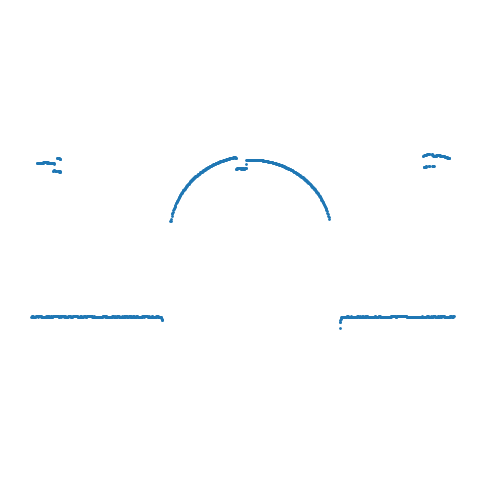

In [12]:
df_recuperado = pd.read_csv('../pruebas_perfilometria/perfiles_2.csv')
diccionario_recuperado = {i: group[['X', 'Y']].values for i, group in df_recuperado.groupby('Array_ID')}



points = diccionario_recuperado[0]

f,ax = plt.subplots(figsize=(6,6))
ax.scatter(points[:,0], points[:,1], s = 1)
ax.axis('off')
ax.axis('equal')
plt.show()